# Path Traversals

In [1]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.append('/mnt/data1/spatial/tissue-alignment/traversal')
from io_utils import read_image, read_spatial_data, read_transcription_data, read_embedding_data
from plot import draw_start, draw_path, draw_clusters
from graph import compute_distance_matrix, compute_path_idxs, compute_clusters, compute_path_counts

In [2]:
model = 'triplet-gi-0999'
fullres = False

In [3]:
cd_path = '/mnt/data1/spatial/data/colon/CD/B'
cd_im = read_image(cd_path, fullres)
cd_pos_df, cd_spot_radius = read_spatial_data(cd_path, fullres)
cd_embeds = read_embedding_data(cd_path, model)
cd_counts = read_transcription_data(cd_path)
cd_start_idx = 2612
cd_end_idx = 1144

uc_path = '/mnt/data1/spatial/data/colon/UC/B'
uc_im = read_image(uc_path, fullres)
uc_pos_df, uc_spot_radius = read_spatial_data(uc_path, fullres)
uc_embeds = read_embedding_data(uc_path, model)
uc_counts = read_transcription_data(uc_path)
uc_start_idx = 241
uc_end_idx = 3601

In [4]:
cd_dists, cd_hex = compute_distance_matrix(cd_embeds, cd_pos_df)
uc_dists, uc_hex = compute_distance_matrix(uc_embeds, uc_pos_df)

In [5]:
cd_path_idxs = compute_path_idxs(cd_dists, cd_hex, cd_start_idx, cd_end_idx)
uc_path_idxs = compute_path_idxs(uc_dists, uc_hex, uc_start_idx, uc_end_idx)

In [6]:
cd_clusters = compute_clusters(cd_embeds, cd_embeds[cd_path_idxs])
uc_clusters = compute_clusters(uc_embeds, uc_embeds[uc_path_idxs])

In [7]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import to_rgba
from matplotlib.patches import Circle

%matplotlib inline

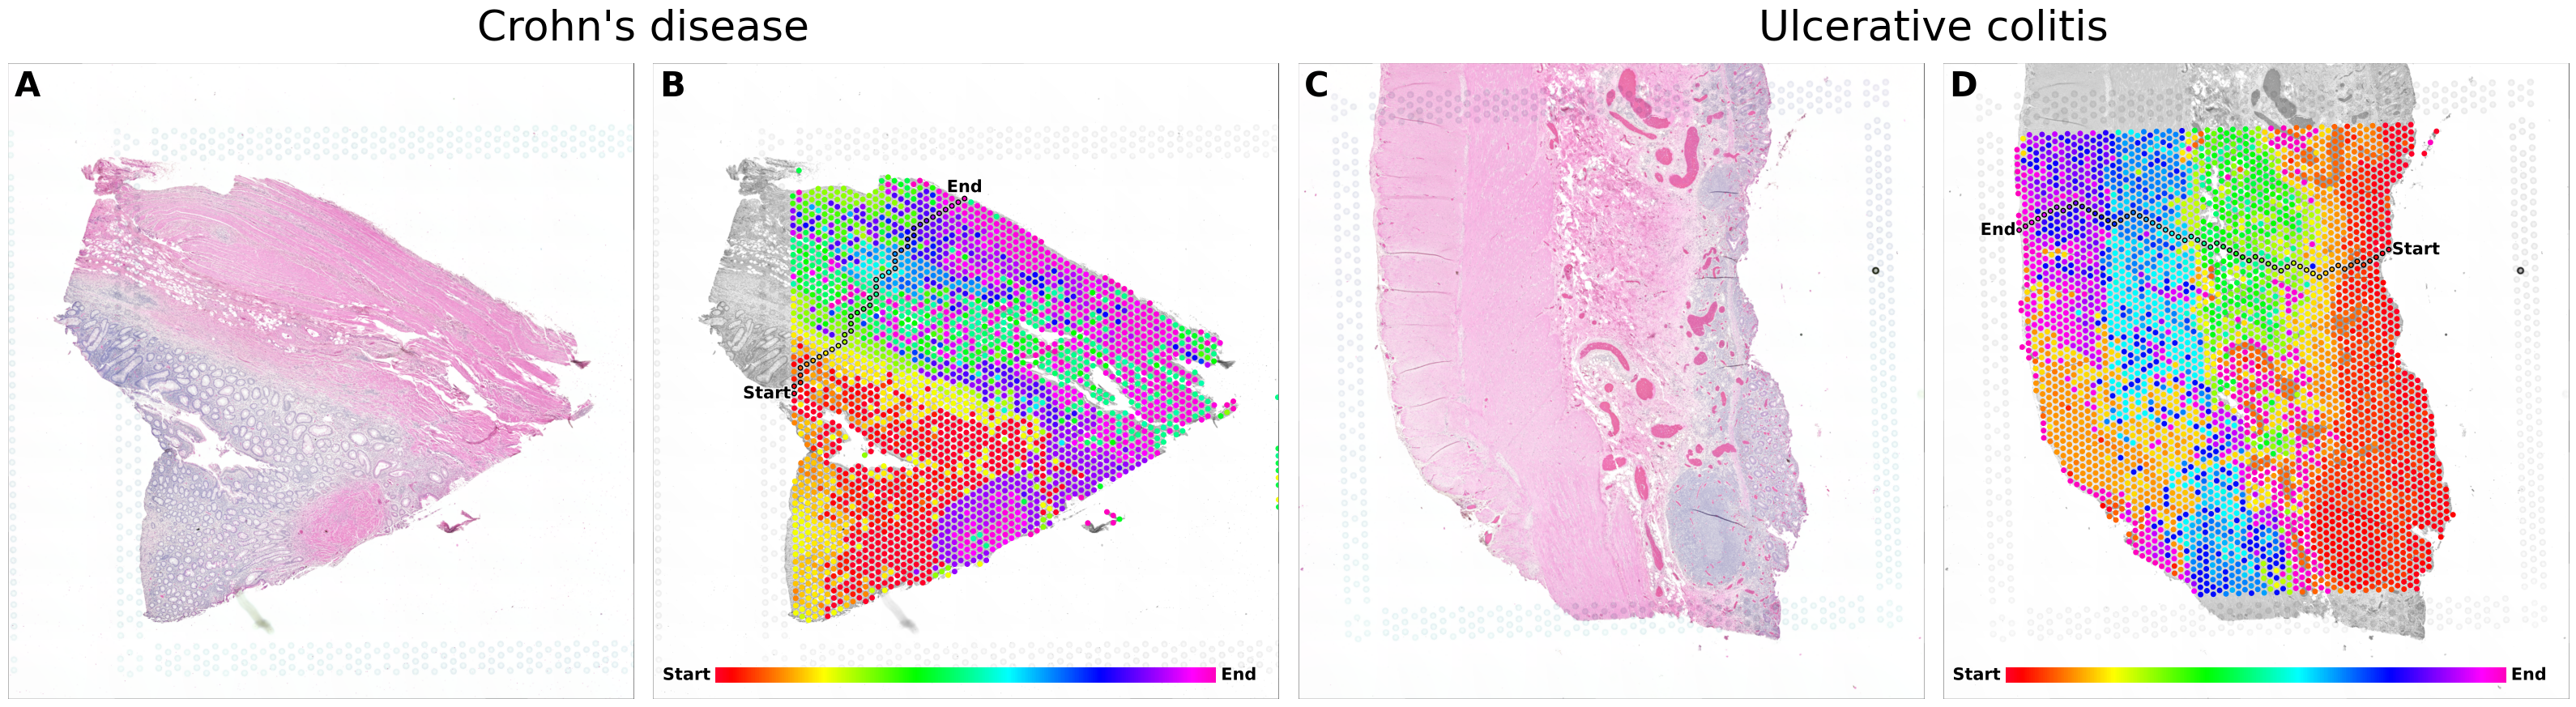

In [12]:
figsize = 8
fontsize=15
alpha = 1
nrows = 1
ncols = 4
plt.close()
fig, axs = plt.subplots(nrows, ncols, figsize=(figsize * ncols, figsize * nrows + figsize/9))
ax1, ax2, ax3, ax4 = axs

ax1.imshow(cd_im)
ax3.imshow(uc_im)

ax2.imshow(np.asarray(cd_im.convert("L")), cmap='gray', vmin=0, vmax=255)
ax4.imshow(np.asarray(uc_im.convert("L")), cmap='gray', vmin=0, vmax=255)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()

cd_circs = PatchCollection(
    [Circle((x, y), cd_spot_radius) for x, y in cd_pos_df[["x", "y"]].to_numpy()],
    picker=True,
)
cd_facecolors = np.asarray([list(to_rgba("lightgray"))] * len(cd_pos_df))
cd_edgecolors = np.asarray([list(to_rgba("darkgray"))] * len(cd_pos_df))
cd_alphas = np.full(len(cd_pos_df), alpha)
cd_circs.set_facecolor(cd_facecolors)
cd_circs.set_edgecolor(cd_edgecolors)
cd_circs.set_alpha(cd_alphas)
ax2.add_collection(cd_circs)

uc_circs = PatchCollection(
    [Circle((x, y), uc_spot_radius) for x, y in uc_pos_df[["x", "y"]].to_numpy()],
    picker=True,
)
uc_facecolors = np.asarray([list(to_rgba("lightgray"))] * len(uc_pos_df))
uc_edgecolors = np.asarray([list(to_rgba("darkgray"))] * len(uc_pos_df))
uc_alphas = np.full(len(uc_pos_df), alpha)
uc_circs.set_facecolor(uc_facecolors)
uc_circs.set_edgecolor(uc_edgecolors)
uc_circs.set_alpha(uc_alphas)
ax4.add_collection(uc_circs)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
ax1_bbox = ax1.get_position()
ax2_bbox = ax2.get_position()
ax3_bbox = ax3.get_position()
ax4_bbox = ax4.get_position()

# dz1_y = ax1_bbox.height / 2 + ax1_bbox.ymin
# fig.text(0.025, dz1_y, 'CD', fontsize=fontsize*2, va='center')

# dz2_y = ax3_bbox.height / 2 + ax4_bbox.ymin
# fig.text(0.025, dz2_y, 'UC', fontsize=fontsize*2, va='center')

# ax1.set_title('H&E Slide', fontsize=fontsize*2)
# ax2.set_title('ATAT Alignment', fontsize=fontsize*2)

dz1_x = (ax2_bbox.xmin - ax1_bbox.xmax) / 2 + ax1_bbox.xmax
dz2_x = (ax4_bbox.xmin - ax3_bbox.xmax) / 2 + ax3_bbox.xmax
dz_y = ax1_bbox.ymax + ax1_bbox.height / 18
fig.text(dz1_x, dz_y, 'Crohn\'s disease', fontsize=fontsize*2.5, va='center', ha='center')
fig.text(dz2_x, dz_y, 'Ulcerative colitis', fontsize=fontsize*2.5, va='center', ha='center')

def _panel_label_coords(bbox, xoffset=0.01, yoffset=0.01):
    x = bbox.width * xoffset + bbox.xmin
    y = bbox.ymax - bbox.height * yoffset
    return x, y

fig.text(*_panel_label_coords(ax1_bbox), 'A', ha='left', va='top', fontsize=fontsize*2, weight='bold')
fig.text(*_panel_label_coords(ax2_bbox), 'B', ha='left', va='top', fontsize=fontsize*2, weight='bold')
fig.text(*_panel_label_coords(ax3_bbox), 'C', ha='left', va='top', fontsize=fontsize*2, weight='bold')
fig.text(*_panel_label_coords(ax4_bbox), 'D', ha='left', va='top', fontsize=fontsize*2, weight='bold')

draw_start(ax2, cd_pos_df, cd_start_idx, 'left', cd_circs, cd_edgecolors, fontsize=fontsize)
draw_path(ax2, cd_pos_df, cd_path_idxs, 'top', cd_circs, cd_edgecolors, fontsize=fontsize)
draw_clusters(fig, ax2, cd_path_idxs, cd_clusters, cd_circs, cd_facecolors, edgecolors=cd_edgecolors, fontsize=fontsize)

draw_start(ax4, uc_pos_df, uc_start_idx, 'right', uc_circs, uc_edgecolors, fontsize=fontsize)
draw_path(ax4, uc_pos_df, uc_path_idxs, 'left', uc_circs, uc_edgecolors, fontsize=fontsize)
draw_clusters(fig, ax4, uc_path_idxs, uc_clusters, uc_circs, uc_facecolors, edgecolors=uc_edgecolors, fontsize=fontsize)

fig.savefig('figs/fig2.png')
fig.savefig('figs/fig2.pdf')

In [9]:
cd_path_counts, _ = compute_path_counts(cd_pos_df, cd_counts, cd_path_idxs, cd_clusters)
cd_path_counts.to_csv('fig2_cd_counts.csv', index=False)
uc_path_counts, _ = compute_path_counts(uc_pos_df, uc_counts, uc_path_idxs, uc_clusters)
uc_path_counts.to_csv('fig2_uc_counts.csv', index=False)

QUEUEING TASKS | :   0%|          | 0/41 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/41 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/41 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/59 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/59 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/59 [00:00<?, ?it/s]